## Importing and reading data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors

In [2]:
# Reading structures 
fl_smiles  = pd.read_csv('data/pca_data_cb1_cb2.csv')
fl_smiles.head()

,smiles,pki_cb1,pki_cb2,diff,cb1
0,O=C(c1c2ccccc2n(CCCCCC)c1C)c3cccc4ccccc43,"7,32","8,40","-1,08",0
1,O=C(c1c2ccccc2n(CCCCC)c1)c3cccc4ccc(OC)cc43,"8,18","8,16","0,02",0
2,Fc1ccc(C(=O)c2c3ccccc3n(CCCCC)c2C)c4ccccc14,"7,85","8,66","-0,81",0
3,O=C(c1c2ccccc2n(n1)CCCCC)c3cccc4ccccc43,"8,23","8,34","-0,11",0
4,FCCCCCn1c2ccccc2c(n1)C(=O)NC34CC5CC(C3)CC(C4)C5,"8,71","9,58","-0,87",0


In [3]:
# Some info about each datset:
print('The shape of FL dataset:  ',fl_smiles.shape)

The shape of FL dataset:   (172, 5)


## Checking duplicated

First, checking if there is any corrupted SMILES on each dataset:

### Checking broken SMILES

In [4]:
def search_broken_smiles(list_of_smiles: list) -> list:
    broken_smiles = []
    # Check every SMILES
    for smiles in list_of_smiles:
        try:
            Chem.MolFromSmiles(smiles)
        except:
            broken_smiles.append(smiles)

    if len(broken_smiles) == 0:
        return False # There are not broken SMILES
    else:
        return broken_smiles 

In [5]:
# Now checking if everything is convertable
if not search_broken_smiles(fl_smiles['smiles'].to_list()):
    print(f'There are not major issues with the conversion of SMILES in the CB1 dataset')

There are not major issues with the conversion of SMILES in the CB1 dataset


### Duplicates

In [6]:
unique_cbd_structures = fl_smiles[~fl_smiles.duplicated(subset=['smiles'])].reset_index(drop=True)
print(unique_cbd_structures.shape)
unique_cbd_structures.tail()

(172, 5)


,smiles,pki_cb1,pki_cb2,diff,cb1
167,O=C(c1c2ccccc2n(c1C)CC)c3cccc4ccccc43,"5,93","6,02","-0,09",0
168,O=C(c1cn(c2ccccc21)C)c3cccc4ccccc43,"5,00","5,00","0,00",0
169,O=C(c1c2ccccc2n(CCCCC)c1C)c3ccc(OC)c4ccccc43,"8,35","8,73","-0,38",0
170,O=C(c1c2ccccc2n(CCCCC)c1C)c3ccc(CCCC)c4ccccc34,"7,38","8,19","-0,81",0
171,Brc1ccc(c2ccccc12)C(=O)c3cn(c4ccccc43)CCC,"6,79","7,57","-0,78",0


## Calculating descriptors

In [7]:
def compute_descriptors(smiles, missingVal=np.nan):
    desc = {}
    desc['smiles'] = smiles

    for name, func in Descriptors._descList:
        try:
            mol = Chem.MolFromSmiles(smiles)
            val = func(mol)
        except:
            val = missingVal
        finally:
            desc[name] = val

    return desc

In [8]:
# Compute descriptors
all_descriptors = [compute_descriptors(smiles) for smiles in unique_cbd_structures['smiles']]

all_descriptors_df = pd.DataFrame(all_descriptors)
print('Number of smiles and descriptors, respectively: ', all_descriptors_df.shape)
all_descriptors_df.head()

Number of smiles and descriptors, respectively:  (172, 209)


,smiles,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,O=C(c1c2ccccc2n(CCCCCC)c1C)c3cccc4ccccc43,13.671395,0.122971,13.671395,0.122971,0.256030,369.508,342.292,369.209264,142,...,0,0,0,0,0,0,0,0,2,0
1,O=C(c1c2ccccc2n(CCCCC)c1)c3cccc4ccc(OC)cc43,13.563052,0.059532,13.563052,0.059532,0.284976,371.480,346.280,371.188529,142,...,0,0,0,0,0,0,0,0,1,0
2,Fc1ccc(C(=O)c2c3ccccc3n(CCCCC)c2C)c4ccccc14,14.225969,-0.300124,14.225969,0.042462,0.273405,373.471,349.279,373.184193,142,...,0,0,0,0,0,0,0,0,1,0
3,O=C(c1c2ccccc2n(n1)CCCCC)c3cccc4ccccc43,13.341739,-0.007184,13.341739,0.007184,0.337032,342.442,320.266,342.173213,130,...,0,0,0,0,0,0,0,0,1,0
4,FCCCCCn1c2ccccc2c(n1)C(=O)NC34CC5CC(C3)CC(C4)C5,13.296340,-0.265302,13.296340,0.002140,0.693199,383.511,353.271,383.237291,150,...,0,0,0,0,0,0,0,0,2,0


### Rule-based descriptors

I took by hand several 'rule-based descriptors' so we can compare the dimensionality reduction using both all the descriptors and only rule_based.

In [9]:
rule_based_descriptors = [
    'ExactMW',
    'FractionCSP3',
    'NumAliphaticHeterocycles',
    'NumAliphaticRings',
    'NumAmideBonds',
    'NumAromaticHeterocycles',
    'NumAromaticRings',
    'NumAtomStereocenters',
    'NumAtoms',
    'NumBridgeheadAtoms',
    'NumHBA',
    'NumHBD',
    'NumHeavyAtoms',
    'NumHeteroatoms',
    'NumHeterocycles',
    'LipinskiHBA',
    'LipinskiHBD',
    'NumRings',
    'NumRotatableBonds',
    'NumSaturatedRings',
    'TPSA',
    'CrippenClogP'
]

rule_based_descriptors = [desc.lower() for desc in rule_based_descriptors]
descriptor_names = list(rdMolDescriptors.Properties.GetAvailableProperties())
rule_based_properties = [desc for desc in descriptor_names if desc.lower() in rule_based_descriptors]

rule_based_properties

['exactmw',
 'lipinskiHBA',
 'lipinskiHBD',
 'NumRotatableBonds',
 'NumHBD',
 'NumHBA',
 'NumHeavyAtoms',
 'NumAtoms',
 'NumHeteroatoms',
 'NumAmideBonds',
 'FractionCSP3',
 'NumRings',
 'NumAromaticRings',
 'NumAliphaticRings',
 'NumSaturatedRings',
 'NumHeterocycles',
 'NumAromaticHeterocycles',
 'NumAliphaticHeterocycles',
 'NumBridgeheadAtoms',
 'NumAtomStereoCenters',
 'tpsa',
 'CrippenClogP']

In [10]:
def rule_based_descriptors(smiles, descriptors_list):
    properties = rdMolDescriptors.Properties(descriptors_list)
    
    rule_based_desc = {}
    rule_based_desc['smiles'] = smiles
    mol = Chem.MolFromSmiles(smiles)

    for name, value in zip(properties.GetPropertyNames(), properties.ComputeProperties(mol)):
        rule_based_desc[name] = value
    return rule_based_desc

In [11]:
manual_descriptors = []
for smiles in unique_cbd_structures['smiles']:
    desc = rule_based_descriptors(smiles, rule_based_properties)
    manual_descriptors.append(desc)

rule_descriptors_df = pd.DataFrame(manual_descriptors)
rule_descriptors_df

,smiles,exactmw,lipinskiHBA,lipinskiHBD,NumRotatableBonds,NumHBD,NumHBA,NumHeavyAtoms,NumAtoms,NumHeteroatoms,...,NumAromaticRings,NumAliphaticRings,NumSaturatedRings,NumHeterocycles,NumAromaticHeterocycles,NumAliphaticHeterocycles,NumBridgeheadAtoms,NumAtomStereoCenters,tpsa,CrippenClogP
0,O=C(c1c2ccccc2n(CCCCCC)c1C)c3cccc4ccccc43,369.209264,2.0,0.0,7.0,0.0,2.0,28.0,55.0,2.0,...,4.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,22.00,6.91422
1,O=C(c1c2ccccc2n(CCCCC)c1)c3cccc4ccc(OC)cc43,371.188529,3.0,0.0,7.0,0.0,3.0,28.0,53.0,3.0,...,4.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,31.23,6.22430
2,Fc1ccc(C(=O)c2c3ccccc3n(CCCCC)c2C)c4ccccc14,373.184193,2.0,0.0,6.0,0.0,2.0,28.0,52.0,3.0,...,4.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,22.00,6.66322
3,O=C(c1c2ccccc2n(n1)CCCCC)c3cccc4ccccc43,342.173213,3.0,0.0,6.0,0.0,3.0,26.0,48.0,3.0,...,4.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,34.89,5.61070
4,FCCCCCn1c2ccccc2c(n1)C(=O)NC34CC5CC(C3)CC(C4)C5,383.237291,4.0,1.0,7.0,1.0,3.0,28.0,58.0,5.0,...,2.0,4.0,4.0,1.0,1.0,0.0,4.0,0.0,46.92,4.87470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,O=C(c1c2ccccc2n(c1C)CC)c3cccc4ccccc43,313.146664,2.0,0.0,3.0,0.0,2.0,24.0,43.0,2.0,...,4.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,22.00,5.35382
168,O=C(c1cn(c2ccccc21)C)c3cccc4ccccc43,285.115364,2.0,0.0,2.0,0.0,2.0,22.0,37.0,2.0,...,4.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,22.00,4.56250
169,O=C(c1c2ccccc2n(CCCCC)c1C)c3ccc(OC)c4ccccc43,385.204179,3.0,0.0,7.0,0.0,3.0,29.0,56.0,3.0,...,4.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,31.23,6.53272
170,O=C(c1c2ccccc2n(CCCCC)c1C)c3ccc(CCCC)c4ccccc34,411.256215,2.0,0.0,9.0,0.0,2.0,31.0,64.0,2.0,...,4.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,22.00,7.86672


## Pre processing

### NA values:

A good strategy that I like to adopt to deal with NA values is to see it in a seaborn heatmap:

Text(0.5, 1.0, 'NA heatmap for all descriptors')

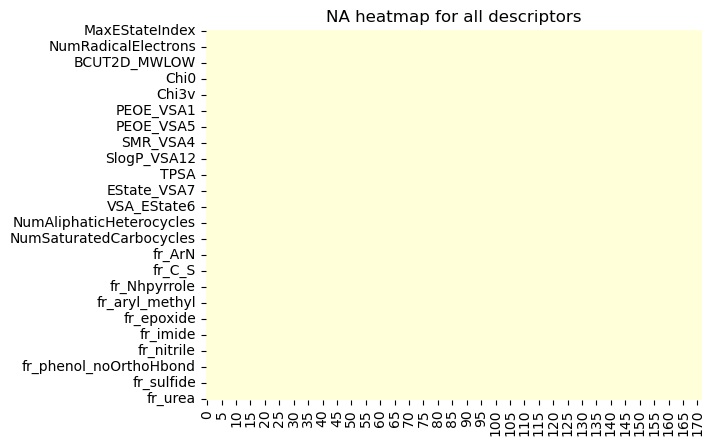

In [12]:
g = sns.heatmap(all_descriptors_df.drop(['smiles'], axis=1).isna().transpose(), cmap='YlGnBu', cbar=False)
g.set_title('NA heatmap for all descriptors')

Text(0.5, 1.0, 'NA heatmap for rule descriptors')

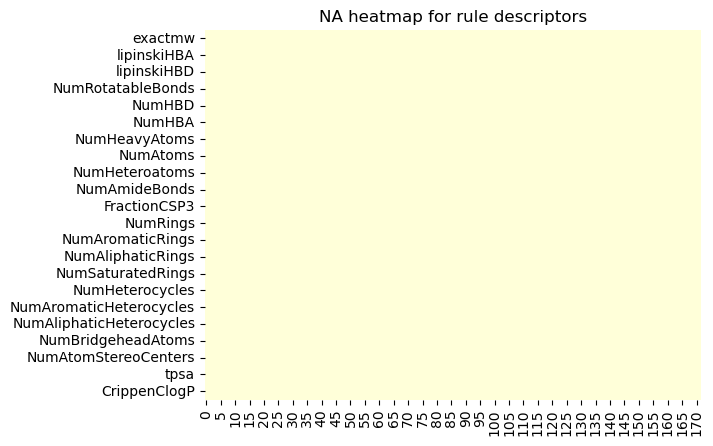

In [13]:
h = sns.heatmap(rule_descriptors_df.drop(['smiles'], axis=1).isna().transpose(), cmap='YlGnBu', cbar=False)
h.set_title('NA heatmap for rule descriptors')

## Filter variance, scaling

There are no NAs values so that is a good thing. First we will need to filter some descriptors from the dataset with all the descriptors, there should be some noise (e.g. variables with near zero variance)

In [14]:
from sklearn.feature_selection import VarianceThreshold
X = all_descriptors_df.drop(['smiles'], axis=1)

selector = VarianceThreshold()
select_variables = selector.fit_transform(X)

# Non-zero variance:
all_descriptors_df = all_descriptors_df[all_descriptors_df.columns[selector.get_support(indices=True)]]
all_descriptors_df

,smiles,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumRadicalElectrons,...,fr_isothiocyan,fr_ketone,fr_lactone,fr_morpholine,fr_oxime,fr_para_hydroxylation,fr_phenol,fr_piperzine,fr_prisulfonamd,fr_thiophene
0,O=C(c1c2ccccc2n(CCCCCC)c1C)c3cccc4ccccc43,13.671395,0.122971,13.671395,0.122971,0.256030,369.508,342.292,369.209264,0,...,0,1,0,0,0,1,0,0,0,0
1,O=C(c1c2ccccc2n(CCCCC)c1)c3cccc4ccc(OC)cc43,13.563052,0.059532,13.563052,0.059532,0.284976,371.480,346.280,371.188529,0,...,0,1,0,0,0,1,0,0,0,0
2,Fc1ccc(C(=O)c2c3ccccc3n(CCCCC)c2C)c4ccccc14,14.225969,-0.300124,14.225969,0.042462,0.273405,373.471,349.279,373.184193,0,...,0,1,0,0,0,1,0,0,0,0
3,O=C(c1c2ccccc2n(n1)CCCCC)c3cccc4ccccc43,13.341739,-0.007184,13.341739,0.007184,0.337032,342.442,320.266,342.173213,0,...,0,1,0,0,0,1,0,0,0,0
4,FCCCCCn1c2ccccc2c(n1)C(=O)NC34CC5CC(C3)CC(C4)C5,13.296340,-0.265302,13.296340,0.002140,0.693199,383.511,353.271,383.237291,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,O=C(c1c2ccccc2n(c1C)CC)c3cccc4ccccc43,13.411030,0.104352,13.411030,0.104352,0.467031,313.400,294.248,313.146664,0,...,0,1,0,0,0,1,0,0,0,0
168,O=C(c1cn(c2ccccc21)C)c3cccc4ccccc43,13.074267,0.077407,13.074267,0.077407,0.494710,285.346,270.226,285.115364,0,...,0,1,0,0,0,1,0,0,0,0
169,O=C(c1c2ccccc2n(CCCCC)c1C)c3ccc(OC)c4ccccc43,13.783886,0.075736,13.783886,0.075736,0.267330,385.507,358.291,385.204179,0,...,0,1,0,0,0,1,0,0,0,0
170,O=C(c1c2ccccc2n(CCCCC)c1C)c3ccc(CCCC)c4ccccc34,13.950416,0.139984,13.950416,0.139984,0.202809,411.589,378.325,411.256215,0,...,0,1,0,0,0,1,0,0,0,0


## PCA

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

plt.style.use('ggplot')

In [16]:
all_descriptors_df = pd.merge(all_descriptors_df,unique_cbd_structures[['smiles', 'cb1']], on='smiles', how='left' )
Y = all_descriptors_df['cb1']
all_descriptors_df.drop('cb1', inplace=True, axis=1)

all_descriptors_df.index = all_descriptors_df['smiles']
all_descriptors_df.drop(['smiles'], axis=1, inplace=True)
all_descriptors_df

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumRadicalElectrons,MaxPartialCharge,...,fr_isothiocyan,fr_ketone,fr_lactone,fr_morpholine,fr_oxime,fr_para_hydroxylation,fr_phenol,fr_piperzine,fr_prisulfonamd,fr_thiophene
smiles,,,,,,,,,,,,,,,,,,,,,
O=C(c1c2ccccc2n(CCCCCC)c1C)c3cccc4ccccc43,13.671395,0.122971,13.671395,0.122971,0.256030,369.508,342.292,369.209264,0,0.195578,...,0,1,0,0,0,1,0,0,0,0
O=C(c1c2ccccc2n(CCCCC)c1)c3cccc4ccc(OC)cc43,13.563052,0.059532,13.563052,0.059532,0.284976,371.480,346.280,371.188529,0,0.195304,...,0,1,0,0,0,1,0,0,0,0
Fc1ccc(C(=O)c2c3ccccc3n(CCCCC)c2C)c4ccccc14,14.225969,-0.300124,14.225969,0.042462,0.273405,373.471,349.279,373.184193,0,0.195581,...,0,1,0,0,0,1,0,0,0,0
O=C(c1c2ccccc2n(n1)CCCCC)c3cccc4ccccc43,13.341739,-0.007184,13.341739,0.007184,0.337032,342.442,320.266,342.173213,0,0.213989,...,0,1,0,0,0,1,0,0,0,0
FCCCCCn1c2ccccc2c(n1)C(=O)NC34CC5CC(C3)CC(C4)C5,13.296340,-0.265302,13.296340,0.002140,0.693199,383.511,353.271,383.237291,0,0.272360,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
O=C(c1c2ccccc2n(c1C)CC)c3cccc4ccccc43,13.411030,0.104352,13.411030,0.104352,0.467031,313.400,294.248,313.146664,0,0.195578,...,0,1,0,0,0,1,0,0,0,0
O=C(c1cn(c2ccccc21)C)c3cccc4ccccc43,13.074267,0.077407,13.074267,0.077407,0.494710,285.346,270.226,285.115364,0,0.195302,...,0,1,0,0,0,1,0,0,0,0
O=C(c1c2ccccc2n(CCCCC)c1C)c3ccc(OC)c4ccccc43,13.783886,0.075736,13.783886,0.075736,0.267330,385.507,358.291,385.204179,0,0.195582,...,0,1,0,0,0,1,0,0,0,0


In [17]:
scaler = StandardScaler()
scaler.fit(all_descriptors_df)
all_descriptors_scaled = scaler.transform(all_descriptors_df)

In [18]:
pca = PCA(n_components = 3)
pca.fit(all_descriptors_scaled)
pca_all_desc = pca.transform(all_descriptors_scaled)

### Visualization

In [29]:
cdict = {0:'m',1:'c'}
label = {0:'CB2',1:'CB1'}
marker = {0:'v', 1:'.'}

In [30]:
Xax = pca_all_desc[:,0]
Yax = pca_all_desc[:,1]
Zax = pca_all_desc[:,2]

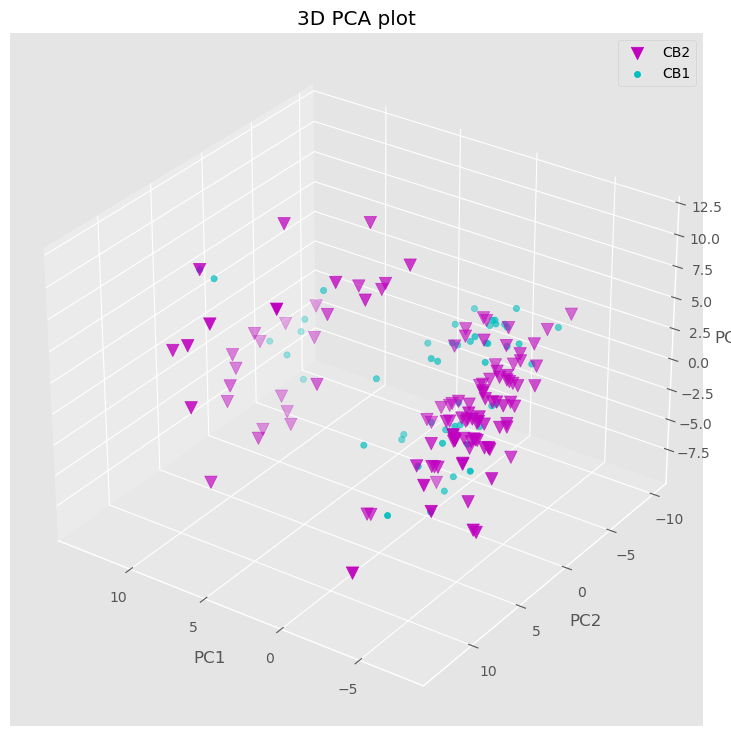

In [31]:
fig = plt.figure(figsize=(14,9))
ax = fig.add_subplot(111, 
                     projection='3d')

                     
for l in np.unique(Y):
 ix=np.where(Y==l)
 ax.scatter(Xax[ix], 
            Yax[ix], 
            Zax[ix], 
            c=cdict[l], 
            s=80,
            marker = marker[l],
           label=label[l])
 
ax.set_xlabel("PC1", 
              fontsize=12)
ax.set_ylabel("PC2", 
              fontsize=12)
ax.set_zlabel("PC3", 
              fontsize=12)
 
ax.view_init(30, 125)
ax.legend()
plt.title("3D PCA plot")
plt.show()